In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import random
from shapely.geometry import Point
from shapely import contains_xy

# Import functions from functions.py
from functions import generate_random_location_within_map_domain, get_flood_depth, calculate_basic_flood_damage, floodplain_multipolygon
import networkx as nx
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batch_run
import geopandas as gpd
import rasterio as rs
import matplotlib.pyplot as plt
# Import the agent class(es) from agents.py
from agents import Households
from agents import Government
from rbb import OrganizationInstrument

# Import functions from functions.py
from functions import get_flood_map_data, calculate_basic_flood_damage
from functions import map_domain_gdf, floodplain_gdf

from model import AdaptationModel

In [2]:
# # Initialize the Adaptation Model with 50 household agents.
# model = AdaptationModel(
#     seed = random.seed(42),
#     number_of_households=50, 
#     flood_map_choice="harvey", 
#     network="watts_strogatz",
#     government_decision = False) # flood_map_choice can be "harvey", "100yr", or "500yr"

# for step in range(120):
#     model.step()

# model_data = model.datacollector.get_model_vars_dataframe()
# # model_data
# # fig, (ax1, ax2) = plt.subplot(2, 1)
# sns.lineplot(model_data["total_adapted_households"], label='cumulatief')
# sns.lineplot(model_data['total_decisions_to_adapt'], label='per stap')
# plt.legend()
# agent_data = model.datacollector.get_agent_vars_dataframe()

In [3]:
dyke = OrganizationInstrument(name = 'Dyke', cost = 8, completion_time = 5, protection_level = 0.7, status = 1)
wetland = OrganizationInstrument(name = 'Wetland', cost = 5,  completion_time = 2, protection_level = 0.4, status = 1)  
options_list = [dyke, wetland]

## Batchrunner

In [4]:
params = {
    "seed": 42,
    "options_list": None,
    "number_of_households": 100,
    "flood_map_choice": 'harvey',
    "network": 'watts_strogatz', #["erdos_renyi", "barabasi_albert", "watts_strogatz"],
    "probability_of_network_connection": 0.4,
    "number_of_edges" : 3,"number_of_nearest_neighbours" : 5,

    "flood_probability" : 0.05,
    "economic_status": 'neutral',
    "intention_action_gap" : 0.3,
    "low_threshold" : 0.6,
    "medium_threshold" : 0.7,
    "high_threshold" : 0.8,
    "upper_budget_threshold" : 7000,
    "lower_budget_threshold" : 3000,
    "elevation_time" : 4,
    "elevation_cost" : 5000,
    "elevation_protection" : 0.3,
    "elevation_effectiveness" : 1,
    "wet_proofing_time" : 2,
    "wet_proofing_cost" : 3000,
    "wet_proofing_effectiveness" : 0.4,
    "dry_proofing_time" : 1,
    "dry_proofing_cost" : 1500,
    "dry_proofing_protection" : 1,
    "dry_proofing_effectiveness" : 0.85,
    "max_damage_costs" : 5000,
    "flood_risk_threshold": 1.5,
    "public_concern_threshold": 0.6,
    "damage_threshold": 0.3,
    "high_risk_bound": 2.9,
    "lower_risk_bound": 1.9,
    "gov_detector": 0,
    "gov_structure": 'centralised',
          }

results = batch_run(
    AdaptationModel,
    parameters=params,
    iterations=5,
    max_steps=120,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
complete_df = pd.DataFrame(results)
subset_df = complete_df[['iteration', 'Step', 'seed', 
                           'options_list', 'number_of_households', 
                           'Average Adaptation Motivation', 'Flood', 'Average flood damage', 
                           'total_adapted_households', 'total_decisions_to_adapt']]
df_no_agent = subset_df.drop_duplicates().reset_index().drop(columns=['index'])
df_final = df_no_agent
df_final.replace({True: 1, False: 0}, inplace=True)

,iteration,Step,seed,options_list,number_of_households,Average Adaptation Motivation,Flood,Average flood damage,total_adapted_households,total_decisions_to_adapt
0,0,0,42,None,100,0.499300,0,0.000000,0,0
1,0,1,42,None,100,0.501217,0,0.000000,7,7
2,0,2,42,None,100,0.503725,0,0.000000,14,7
3,0,3,42,None,100,0.507107,0,0.000000,15,2
4,0,4,42,None,100,0.512000,0,0.000000,17,2
...,...,...,...,...,...,...,...,...,...,...
600,4,116,42,None,100,0.650782,0,0.385706,50,0
601,4,117,42,None,100,0.649746,0,0.385706,50,0
602,4,118,42,None,100,0.648798,1,0.422856,50,0
603,4,119,42,None,100,0.668499,0,0.422856,49,1


In [44]:
def plot_KPI(df, kpi, c = 'blue', n_iterations = 5):
    g = sns.FacetGrid(df, col_wrap = n_iterations, col = 'iteration')
    g.fig.suptitle(kpi + "in basecase for different iterations")
    g.map(sns.lineplot,x = df['Step'], y= df_final[kpi], color = c, label = kpi)
    plt.legend()
    g.set_axis_labels(x_var = "Timestep, quarterly", y_var = kpi)
    g.set(xticks = list(range(0, 121, 20)))
    plt.show()

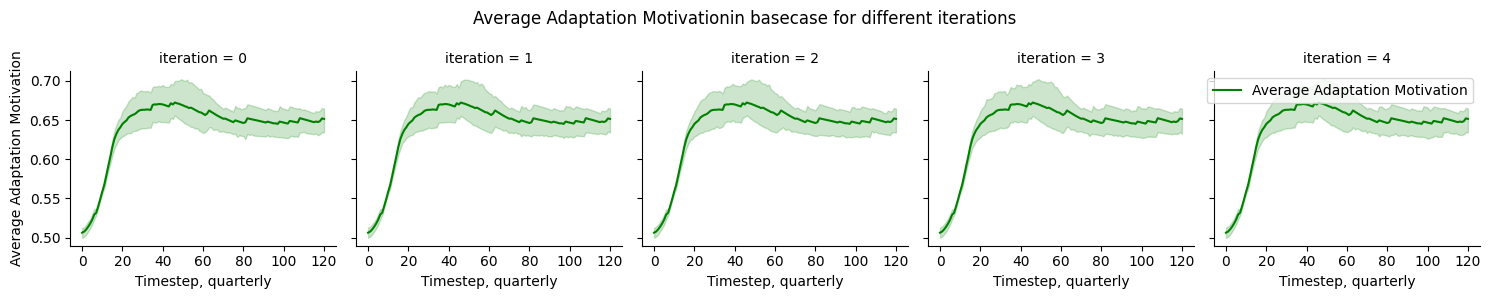

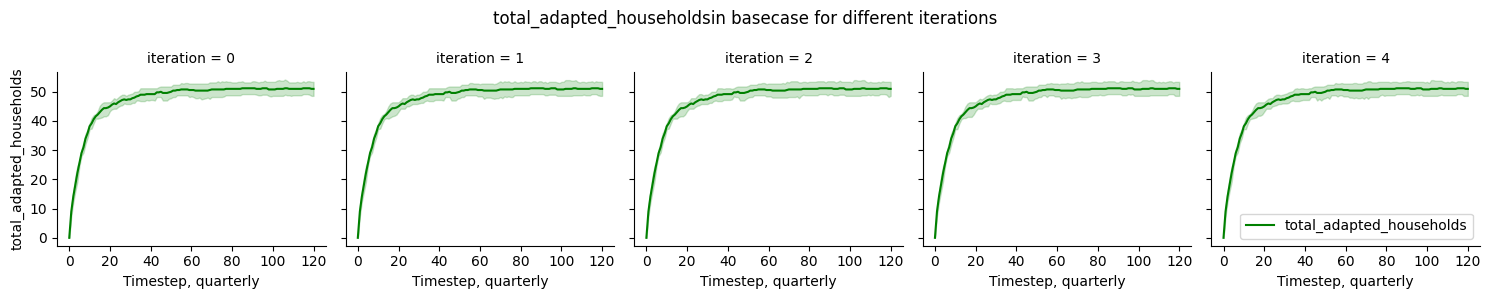

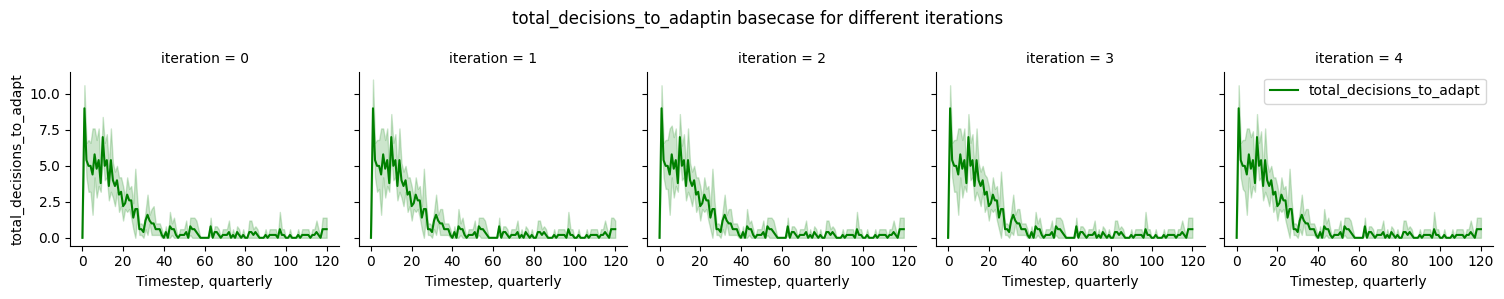

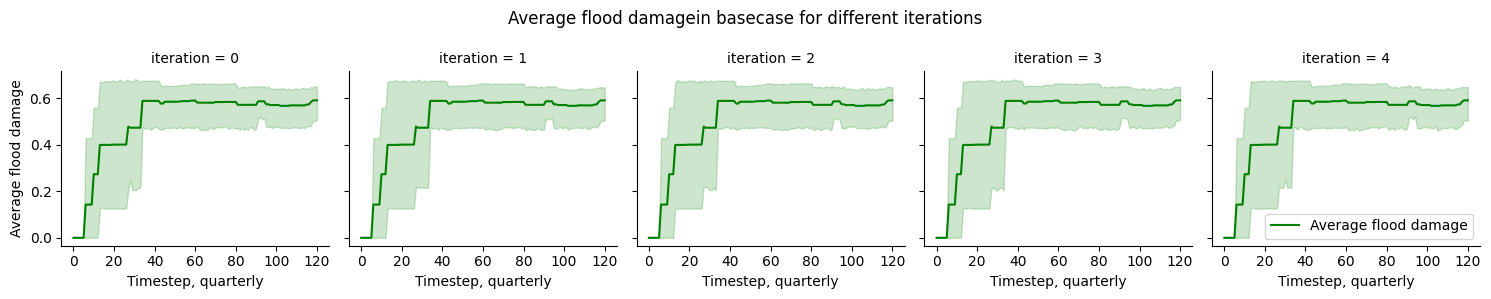

In [45]:
KPIs = ['Average Adaptation Motivation', 'total_adapted_households', 'total_decisions_to_adapt', 'Average flood damage']
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'pink', 'purple', 'grey']
for i in len(KPIs):
    plot_KPI(df_final, KPIs[i], colors[i], 5)

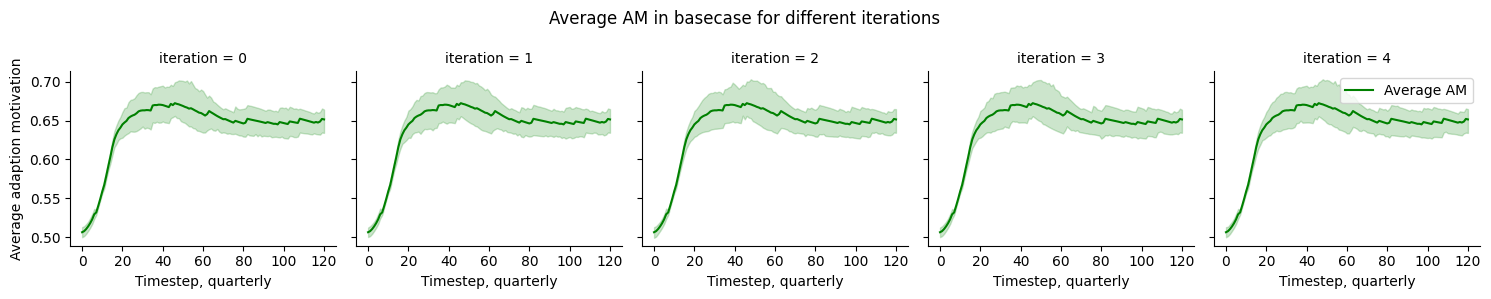

KeyboardInterrupt: 

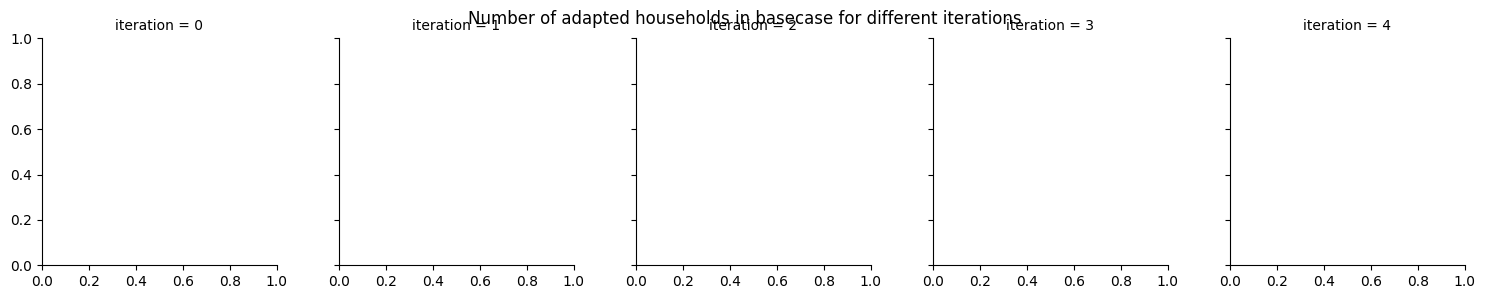

In [42]:

# g = sns.FacetGrid(df_final, col_wrap = 5, col = 'iteration')
# g.fig.suptitle("Average AM in basecase for different iterations")
# g.map(sns.lineplot,x = df_final['Step'], y= df_final['Average Adaptation Motivation'], color = 'green', label = 'Average AM')
# plt.legend()
# g.set_axis_labels(x_var = "Timestep, quarterly", y_var = "Average adaption motivation")
# g.set(xticks = list(range(0, 121, 20)))
# plt.show()

# g = sns.FacetGrid(df_final, col_wrap = 5, col = 'iteration')
# g.fig.suptitle("Number of adapted households in basecase for different iterations")
# g.map(sns.lineplot,x = df_final['Step'], y= df_final['total_adapted_households'], color = 'blue', label = 'Adapted households')
# plt.legend()
# g.set_axis_labels(x_var = "Timestep, quarterly", y_var = "Average adaption motivation")
# g.set(xticks = list(range(0, 121, 20)))
# plt.show()

# g = sns.FacetGrid(df_final, col_wrap = 5, col = 'iteration')
# g.fig.suptitle("Number of decisions to adapt in basecase for different iterations")
# g.map(sns.lineplot,x = df_final['Step'], y= df_final['total_decisions_to_adapt'], color = 'red', label = 'Decisions to adapt')
# plt.legend()
# g.set_axis_labels(x_var = "Timestep, quarterly", y_var = "Average adaption motivation")
# g.set(xticks = list(range(0, 121, 20)))
# plt.show()

# g = sns.FacetGrid(df_final, col_wrap = 5, col = 'iteration')
# g.fig.suptitle("Average flood damage in basecase for different iterations")
# g.map(sns.lineplot,x = df_final['Step'], y= df_final['Average flood damage'], color = 'red', label = 'Average flood damage')
# plt.legend()
# g.set_axis_labels(x_var = "Timestep, quarterly", y_var = "Average adaption motivation")
# g.set(xticks = list(range(0, 121, 20)))
# plt.show()
# #plt.savefig("WASTE_PLASTIC_BASECASE.png", dpi=100,bbox_inches='tight')

